In [28]:
import pandas as pd
import numpy as np
import imageio
import os
from glob import glob
import matplotlib.pyplot as plt
import time
import sys
sys.path.append('..')
from inference.interact.interactive_utils import overlay_davis
from PIL import Image

csv_name1 = '/home/venom/.exp/1108_Ablation/D0232_freeze=0,fuse_type=cbam,num_frames=8,steps=1000,use_text=0,use_flow=0/eval_10000/all/all_per-sequence_results-val.csv'
csv_name2 = '/home/venom/.exp/1105_retrain_XMem/D0209_freeze=0,fuse_type=cbam,num_frames=8,steps=1000,use_text=0,use_flow=1/eval_10000/all/all_per-sequence_results-val.csv'

csv1 = pd.read_csv(csv_name1)
csv2 = pd.read_csv(csv_name2)
data_merge = pd.merge(csv1, csv2, on='narration', how='outer')
data_merge = data_merge.drop(columns='Sequence_y')
data_merge.fillna(0, inplace=True)
data_merge['J_diff'] = data_merge['J-Mean_y'] - data_merge['J-Mean_x'] # csv2-csv1
data_merge['F_diff'] = data_merge['F-Mean_y'] - data_merge['F-Mean_x'] # csv2-csv1
data_merge = data_merge.sort_values(by='J_diff', ascending=False)

data_merge[['J-Mean_x', 'J-Mean_y', 'F-Mean_x', 'F-Mean_y', 'J_diff', 'F_diff']] = data_merge[['J-Mean_x', 'J-Mean_y', 'F-Mean_x', 'F-Mean_y', 'J_diff', 'F_diff']].astype('float16')

data_merge.to_csv('./tmp.csv', index=False)
print(data_merge)
print('----')

       narration                Sequence_x  J-Mean_x  F-Mean_x  Blob-Mean_x  \
19   P02_12_33_1                  mix meat  0.464111  0.173950        0.414   
16   P01_14_95_1    still dicing aubergine  0.336914  0.604980        0.326   
51   P11_20_37_1  pour fishcakes onto foil  0.558105  0.672852        0.475   
46   P08_16_84_1           cut lemon slice  0.622070  0.800781        0.608   
36   P07_14_42_1                cut banana  0.574219  0.599121        0.482   
..           ...                       ...       ...       ...          ...   
81    P28_19_4_1               chop pepper  0.650879  0.937988        0.495   
91  P29_05_351_1               chop potato  0.708984  0.910156        0.557   
90  P29_05_350_1               chop potato  0.615234  0.892090        0.425   
60   P18_01_40_1             separate them  0.648926  0.869141        0.425   
83   P28_24_13_1               chop tomato  0.693848  0.950195        0.694   

    J-Mean_y  F-Mean_y  Blob-Mean_y    J_diff    F_

## visualize images

/home/venom/.exp/1108_Ablation/D0232_freeze=0,fuse_type=cbam,num_frames=8,steps=1000,use_text=0,use_flow=0/eval_10000/all
/home/venom/.exp/1105_retrain_XMem/D0209_freeze=0,fuse_type=cbam,num_frames=8,steps=1000,use_text=0,use_flow=1/eval_10000/all
/home/venom/projects/XMem/val_data


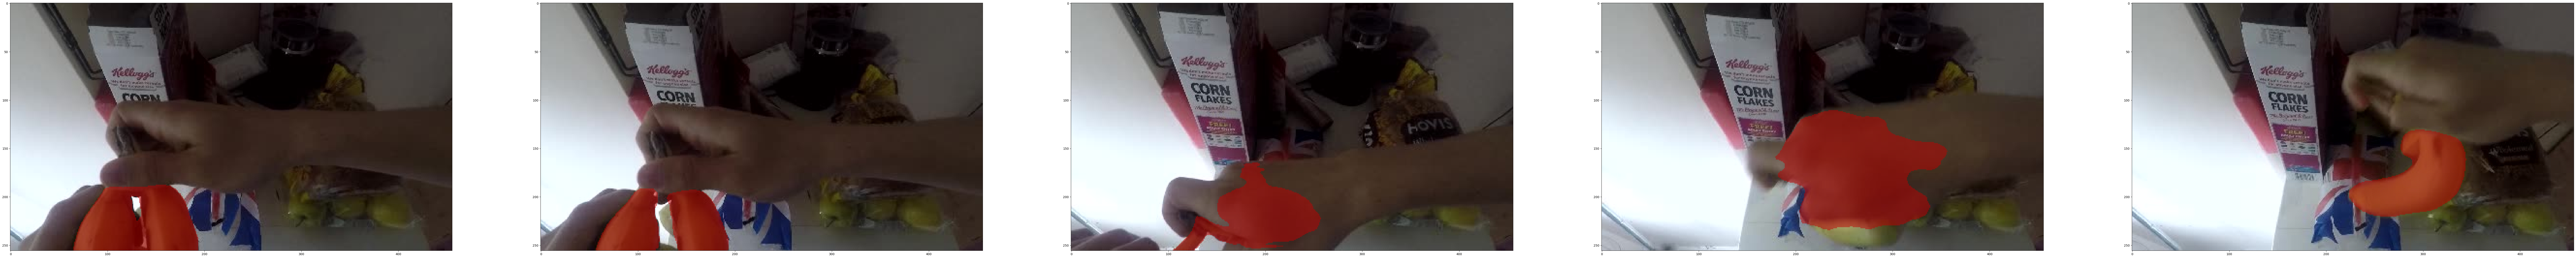

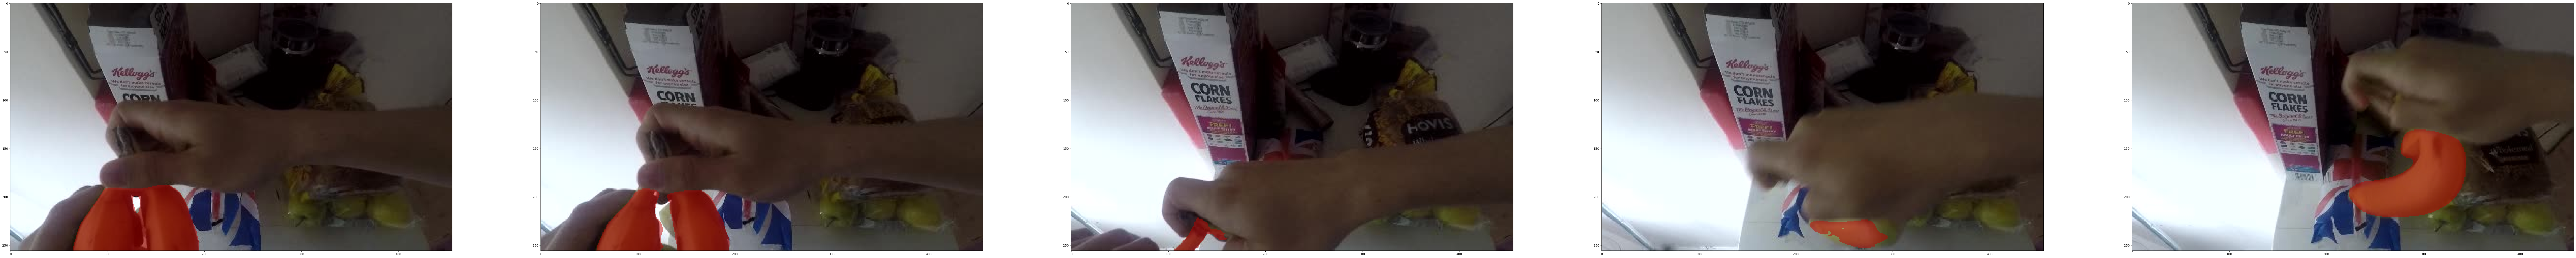

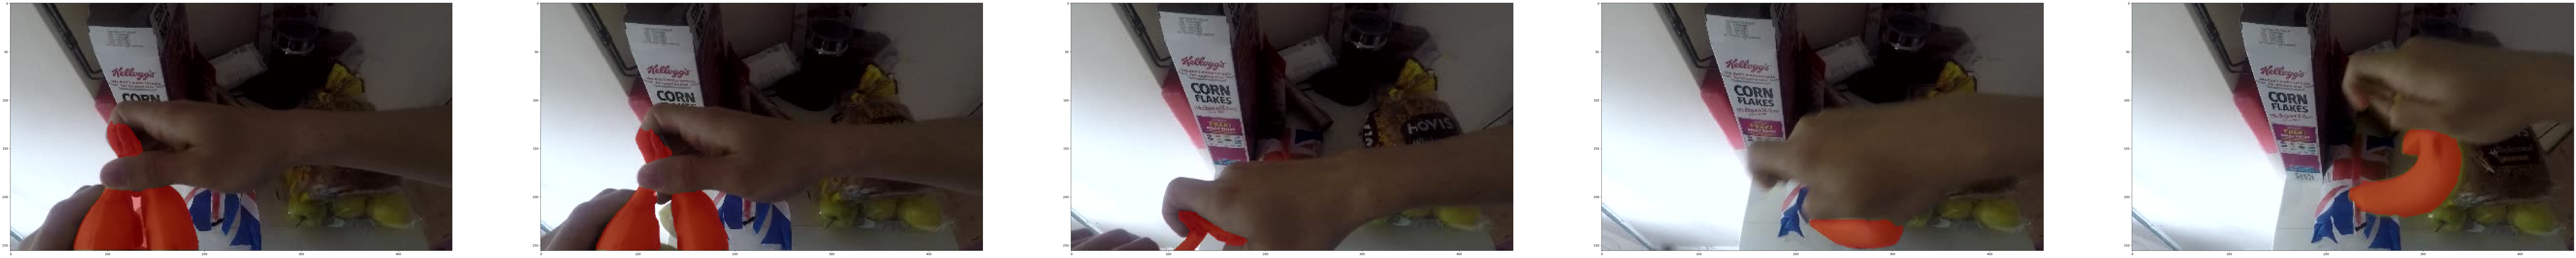

In [37]:
val_data_path = '/home/venom/projects/XMem/val_data'
run1_dir = '/'.join(csv_name1.split('/')[:-1])
run2_dir = '/'.join(csv_name2.split('/')[:-1])

save_pdf = True
cols = 5
rows = 3
alpha = 0.5
key = 'P07_14_42'
PART = key.split('_')[0]
video_id = '_'.join(key.split('_')[:2])
anno_path = os.path.join(val_data_path, PART, 'anno_masks', video_id, key)
annoted_imgs = sorted(glob(f'{anno_path}/*.png'))[1:-1]
selected_annos = sorted(np.random.choice(annoted_imgs, size=min(len(annoted_imgs), cols), replace=False))
cols = len(selected_annos)
# runs draw
# run1_dir
for row_idx, run_path in enumerate([run1_dir, run2_dir]):
    print(run_path)
    # if not os.path.exists(run_path + '/draw'):
    #     assert os.path.exists(run_path + '/masks.zip')
    #     current_path = os.getcwd()
    #     os.chdir(run_path)
    #     os.system('unzip masks.zip')
    #     if not os.path.exists('./draw'):
    #         current_dir = './u'
    #         while True:
    #             if len(os.listdir(current_dir)) == 1:
    #                 next_dir = os.listdir(current_dir)[0]
    #                 current_dir = os.path.join(current_dir, next_dir)
    #             else:
    #                 os.system(f'mv {current_dir}/* {run_path}')
    #                 break
    #     os.chdir(current_path)
    
    # fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(150, 150))
    run_anno_path = os.path.join(run_path, PART, video_id, key)
    
    # combine frames to gif
    images = []
    fig, axes = plt.subplots(nrows=1, ncols=cols, figsize=(150, 150))
    for i, frame_path in enumerate(selected_annos):
        rgb_path = os.path.join(val_data_path, PART, 'rgb_frames', video_id, key)
        raw_frame_path = os.path.join(rgb_path, frame_path.replace('png', 'jpg').split('/')[-1])
        anno_path = os.path.join(run_anno_path, frame_path.split('/')[-1])
        
        visualization = overlay_davis(np.array(Image.open(raw_frame_path)), np.array(Image.open(anno_path)), alpha=alpha)
        # im = plt.imread(frame_path)
        # plt.subplot(rows,cols,row_idx*len(selected_annos)+i+1)
        axes[i].imshow(visualization)
        # plt.imshow(visualization)
    if save_pdf:
        if run_path == run1_dir:
            fig.savefig(f"../visuals/flow_integrate/{key}_pred_baseline.pdf")
        elif run_path == run2_dir:
            fig.savefig(f"../visuals/flow_integrate/{key}_pred_finetune.pdf")

print(val_data_path)
# fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(150, 150))
anno_path = os.path.join(val_data_path, PART, 'anno_masks', video_id, key)
rgb_path = os.path.join(val_data_path, PART, 'rgb_frames', video_id, key)
images = []
fig, axes = plt.subplots(nrows=1, ncols=cols, figsize=(150, 150))
for i, frame_path in enumerate(selected_annos): 
    raw_frame_path = frame_path.replace('png', 'jpg').split('/')[-1]
    raw_frame_path = os.path.join(rgb_path, raw_frame_path)
    visualization = overlay_davis(np.array(Image.open(raw_frame_path)), np.array(Image.open(frame_path)), alpha=alpha)
    # im = plt.imread(frame_path)
    axes[i].imshow(visualization)
    # plt.subplot(rows, cols,2*len(selected_annos)+i+1)
    # plt.imshow(visualization)
if save_pdf:
    fig.savefig(f"../visuals/flow_integrate/{key}_gt.pdf")
plt.show()

## statistics

In [117]:
# 统计后10%的数据的频次
import pandas as pd
csv_names = ['/home/venom/.exp/1010_ema_ts_all_align_loss=0/D0110_teacher_warmup=100,teacher_loss_weight=0.01,use_text=0,use_flow=1/eval_2000/per-sequence_results-val.csv',
            '/home/venom/.exp/1010_ema_ts_all_align_loss=0/D0110_teacher_warmup=100,teacher_loss_weight=0.01,use_text=0,use_flow=1/eval_10000/per-sequence_results-val.csv',
            '/home/venom/.exp/1010_ema_ts_all_align_loss=0/D0113_teacher_warmup=100,teacher_loss_weight=0.01,use_text=1,use_flow=1/eval_2000/per-sequence_results-val.csv',
            '/home/venom/.exp/1010_ema_ts_all_align_loss=0/D0113_teacher_warmup=100,teacher_loss_weight=0.01,use_text=1,use_flow=1/eval_10000/per-sequence_results-val.csv',
            '/home/venom/.exp/1007_new_valdata_normal_train_CLIPL/D0082_no_align,use_text=1,use_flow=1/eval_15000/per-sequence_results-val.csv',
            '/home/venom/.exp/1007_new_valdata_normal_train_CLIPL/D0082_no_align,use_text=1,use_flow=1/eval_11500/per-sequence_results-val.csv',
            '/home/venom/.exp/1007_new_valdata_normal_train_CLIPL/D0085_no_align,use_text=0,use_flow=0/eval_1000/per-sequence_results-val.csv',
            '/home/venom/.exp/1007_new_valdata_normal_train_CLIPL/D0085_no_align,use_text=0,use_flow=0/eval_15000/per-sequence_results-val.csv',
            '/home/venom/.exp/1006_new_valdata_normal_train/D0080_no_align,use_text=0,use_flow=1/eval_4500/per-sequence_results-val.csv',
            '/home/venom/.exp/1006_new_valdata_normal_train/D0080_no_align,use_text=0,use_flow=1/eval_15000/per-sequence_results-val.csv',
            '/home/venom/.exp/1006_new_valdata_normal_train/D0081_dice_align,use_text=0,use_flow=1/eval_4500/per-sequence_results-val.csv',]

csv_name1 = '/home/venom/.exp/XMem/1003XMem/per-sequence_results-val.csv'

csv1 = pd.read_csv(csv_name1)
# last 10% data
counts_dict = {}
negative_counts = {}
for csv_name in csv_names:
    csv2 = pd.read_csv(csv_name)
    # df = df.sort_values(by='J-Mean', ascending=False)
    data_merge = pd.merge(csv1, csv2, on='narration', how='outer')
    data_merge = data_merge.drop(columns='Sequence_y')
    data_merge.fillna(0, inplace=True)
    data_merge['J_diff'] = data_merge['J-Mean_y'] - data_merge['J-Mean_x'] # csv2-csv1
    data_merge['F_diff'] = data_merge['F-Mean_y'] - data_merge['F-Mean_x'] # csv2-csv1
    data_merge = data_merge.sort_values(by='J_diff', ascending=False)

    data_merge[['J-Mean_x', 'J-Mean_y', 'F-Mean_x', 'F-Mean_y', 'J_diff', 'F_diff']] = data_merge[['J-Mean_x', 'J-Mean_y', 'F-Mean_x', 'F-Mean_y', 'J_diff', 'F_diff']].astype('float16')
    
    for idx, item in enumerate(data_merge[-10:]['narration']):
        item = '_'.join(item.split('_')[:-1])
        if item in negative_counts.keys():
            negative_counts[item]['cnt'] += 1
            negative_counts[item]['num'].append(data_merge.iloc[idx]['J_diff'])
        else:
            negative_counts.update({item: {'cnt': 1, 'num': [data_merge.iloc[idx]['J_diff']]}})
        
        if item not in counts_dict.keys():
            counts_dict.update({item: {'cnt': 0, 'num': []}})

for csv_name in csv_names:
    csv2 = pd.read_csv(csv_name)
    # df = df.sort_values(by='J-Mean', ascending=False)
    data_merge = pd.merge(csv1, csv2, on='narration', how='outer')
    data_merge = data_merge.drop(columns='Sequence_y')
    data_merge.fillna(0, inplace=True)
    data_merge['J_diff'] = data_merge['J-Mean_y'] - data_merge['J-Mean_x'] # csv2-csv1
    data_merge['F_diff'] = data_merge['F-Mean_y'] - data_merge['F-Mean_x'] # csv2-csv1
    data_merge = data_merge.sort_values(by='J_diff', ascending=False)

    data_merge[['J-Mean_x', 'J-Mean_y', 'F-Mean_x', 'F-Mean_y', 'J_diff', 'F_diff']] = data_merge[['J-Mean_x', 'J-Mean_y', 'F-Mean_x', 'F-Mean_y', 'J_diff', 'F_diff']].astype('float16')
    
    for key, value in negative_counts.items():
        num = data_merge.loc[data_merge['narration']==key+'_1']['J_diff']
        counts_dict[key]['cnt'] += 1
        counts_dict[key]['num'].append(num)

# less than 0.5
lt_50_dict = {}
for csv_name in csv_names:
    df = pd.read_csv(csv_name)
    df = df.sort_values(by='J-Mean', ascending=False)
    for item in df[-10:]['narration']:
        key = '_'.join(item.split('_')[:-1])
        if key not in lt_50_dict.keys():
            lt_50_dict.update({key: 1})
        else:
            lt_50_dict[key] += 1

# counts_dict = sorted(counts_dict.items(), key=lambda x: x[1], reverse=True)
# negative_counts = sorted(negative_counts.items(), key=lambda x: x[1], reverse=True)
print('last 10%')
# counts_dict = sorted(counts_dict.items(), key=lambda x: np.mean(x[1]['num']), reverse=True)
new_counts_dict = {}
# print(counts_dict)
for key, value in counts_dict.items():
    value_mean = np.mean(np.array(value['num']))
    value_std = np.std(np.array(value['num']))
    new_counts_dict.update({key: {'cnt':value['cnt'], 'mean': value_mean, 'std': value_std}})
    # print(idx)
new_counts_dict = sorted(new_counts_dict.items(), key=lambda x: x[1]['mean'], reverse=True)
for item in new_counts_dict:
    print(item)

print('-----------less than 0.5------------')
lt_50_dict = sorted(lt_50_dict.items(), key=lambda x: x[1], reverse=True)
print(lt_50_dict)
# print(new_counts_dict)

last 10%
('P29_05_352', {'cnt': 11, 'mean': 0.07245, 'std': 0.1316})
('P06_10_51', {'cnt': 11, 'mean': 0.029, 'std': 0.1002})
('P04_25_23', {'cnt': 11, 'mean': 0.01, 'std': 0.0598})
('P08_16_63', {'cnt': 11, 'mean': -0.01628, 'std': 0.1517})
('P11_20_74', {'cnt': 11, 'mean': -0.01845, 'std': 0.0485})
('P15_04_26', {'cnt': 11, 'mean': -0.01973, 'std': 0.07556})
('P04_24_55', {'cnt': 11, 'mean': -0.02336, 'std': 0.05814})
('P07_14_42', {'cnt': 11, 'mean': -0.02563, 'std': 0.06396})
('P29_05_355', {'cnt': 11, 'mean': -0.0269, 'std': 0.0739})
('P01_14_133', {'cnt': 11, 'mean': -0.03293, 'std': 0.0457})
('P08_14_29', {'cnt': 11, 'mean': -0.0338, 'std': 0.06433})
('P11_17_44', {'cnt': 11, 'mean': -0.03427, 'std': 0.0383})
('P06_12_11', {'cnt': 11, 'mean': -0.03445, 'std': 0.0355})
('P03_23_82', {'cnt': 11, 'mean': -0.03708, 'std': 0.11414})
('P29_05_394', {'cnt': 11, 'mean': -0.03983, 'std': 0.0227})
('P02_12_321', {'cnt': 11, 'mean': -0.0402, 'std': 0.0755})
('P07_14_22', {'cnt': 11, 'mean'

### deprecated


In [ ]:
val_data_path = '/home/venom/projects/XMem/val_data'
run1_dir = '/home/venom/.exp/1003XMem'
run2_dir = '/home/venom/.exp/1010_ema_ts_all_align_loss=0/D0110_teacher_warmup=100,teacher_loss_weight=0.01,use_text=0,use_flow=1/eval_3000'

df = pd.read_csv(csv_path)
df = df.sort_values(by='J_diff', ascending=False)
df_positive = df[df['J_diff'] > 0.1]
df_negative = df[df['J_diff'] < -0.1]
print('--positive--')
for key in df_positive['narration']:
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(150, 150))
    key = '_'.join(key.split('_')[:-1])
    PART = key.split('_')[0]
    video_id = '_'.join(key.split('_')[:2])
    rgb_path = os.path.join(val_data_path, PART, 'rgb_frames', video_id, key)
    selected_frames = np.random.choice(sorted(glob(f'{rgb_path}/*.jpg')),size=5,replace=False)
    # combine frames to gif
    images = []
    print(key)
    for i, frame_path in enumerate(selected_frames):
        im = plt.imread(frame_path)
        axes[i].imshow(im)


In [ ]:
print('--negative--')
for key in df_negative['narration']:
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(150, 150))
    key = '_'.join(key.split('_')[:-1])
    PART = key.split('_')[0]
    video_id = '_'.join(key.split('_')[:2])
    rgb_path = os.path.join(val_data_path, PART, 'rgb_frames', video_id, key)
    selected_frames = np.random.choice(sorted(glob(f'{rgb_path}/*.jpg')),size=5,replace=False)
    # combine frames to gif
    images = []
    print(key)
    for i, frame_path in enumerate(selected_frames):
        im = plt.imread(frame_path)
        axes[i].imshow(im)